<div align="center">
 <img alt="Deep Learning Indaba" src="https://gitlab.com/instadeep-public/grandchallenge/-/raw/master/dlindaba.jpg" />
    <h1>Grand Challenge</h1>
    <br />
</div>

<h1>Basic tools of Bioinformatics and Cheminformatics for <i>Trypanosoma brucei</i></h1>

This notebook focuses on an arbitrary drug target in _T. brucei_ - [ATP-dependent 6-phosphofructokinase](https://en.wikipedia.org/wiki/Phosphofructokinase_1) (*pfk1*). This regulatory enzyme catalyses (enables) an important step in [glycolysis](https://en.wikipedia.org/wiki/Glycolysis) - converting sugars (glucose) into other compounds and obtaining free energy to be stored in form of ATP. 

While this protein is present in organisms across the tree of life, we will be focusing on the _Trypanosoma brucei_ variant and using the available public data. A good first step is a quick survey of [UniProtKb](https://www.uniprot.org/) (UniProt Knowledge Base) - one of authoritative sources aggregating experimental information about proteins. 

A [quick search](https://www.uniprot.org/uniprot/?query=6-phosphofructokinase+trypanosoma&sort=score) allows us to identify the correct entry in the database and its identifier - [O15648](https://www.uniprot.org/uniprot/O15648). The RESTful interface allows for convenient parsing this information - for example in [XML format](https://www.uniprot.org/uniprot/O15648.xml). In addition to the exhaustive information, power of UniProt lies in providing references to information about the subject of an entry in other, [more specialized resources](https://www.uniprot.org/uniprot/O15648#cross_references). For drug discovery, we would be interested in [BindingDB](https://www.bindingdb.org/jsp/dbsearch/PrimarySearch_ki.jsp?polymerid=50004024&tag=pol&target=UNIPROT:O15648&accession_number=O15648&submit=Search), [ChEMBL](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL5686/) or [DrugCentral](http://drugcentral.org/target/O15648/). _In the latter resource we can discover that pfk is a target for a widely-used antitrypanosomal drug - *Suramin*_

The UniProt identifiers are ubiquitous and are very often used as unique keys in other resources, such as [PubChem](https://pubchem.ncbi.nlm.nih.gov), American counterpart to European ChEMBL.  At the entry of [O15648](https://pubchem.ncbi.nlm.nih.gov/protein/O15648) we can see loads of information, in particular section on [Chemicals and Bioactivities](https://pubchem.ncbi.nlm.nih.gov/protein/O15648#section=Chemicals-and-Bioactivities) containing 151 tested compounds, with their activity data.

We will however, be following the protocol used internally at InstaDeep, and using ChEMBL as our data resource. Let's go to the [Activity Charts](https://www.ebi.ac.uk/chembl/g/#browse/activities/filter/target_chembl_id%3ACHEMBL5686) section of the entry and realize that there are over 7,000 studied compounds with known bioactivities! Let's download them all through a *CSV* button. You can download the snapshot used for this work [here](http://

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv('CHEMBL26-molecules.csv', sep=';')
df = df.dropna(subset=['Smiles', 'Molecule ChEMBL ID']).drop_duplicates(subset=['Molecule ChEMBL ID'])

There is a wealth of information stored in these files, all of which may be interesting at some point, but we want just three - an indentifier (ChEMBL ID), the actual compound definition and compound's potency.

In [2]:
df.iloc[0]

Molecule ChEMBL ID                                                CHEMBL1303169
Molecule Name                                                               NaN
Molecule Max Phase                                                            0
Molecular Weight                                                         283.11
#RO5 Violations                                                               0
AlogP                                                                      3.14
Compound Key                                                        SID14732558
Smiles                                          O=C(OCc1ccc(Cl)c(Cl)c1)c1cnccn1
Standard Type                                                           Potency
Standard Relation                                                           NaN
Standard Value                                                          26854.5
Standard Units                                                               nM
pChEMBL Value                           

The compounds here are encoded as [SMILES strings](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system), a compact method of encoding a chemical structure into human-readable, string format. 

While human readable, they are not very human-friendly. Or great to work with in the first place. Let's convert them into something more usable. We will be using [RDKit](https://www.rdkit.org/), the state of art, open-source cheminformatics software. 

It comes with [extensive documentation](https://www.rdkit.org/docs/index.html), including a [comprehensive tutorial](https://www.rdkit.org/docs/GettingStartedInPython.html) demonstrating nearly anything that can be useful for applications like this. 

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import Image

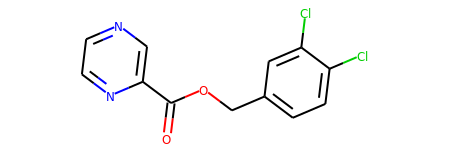

In [4]:
Chem.MolFromSmiles(df.iloc[0]['Smiles'])

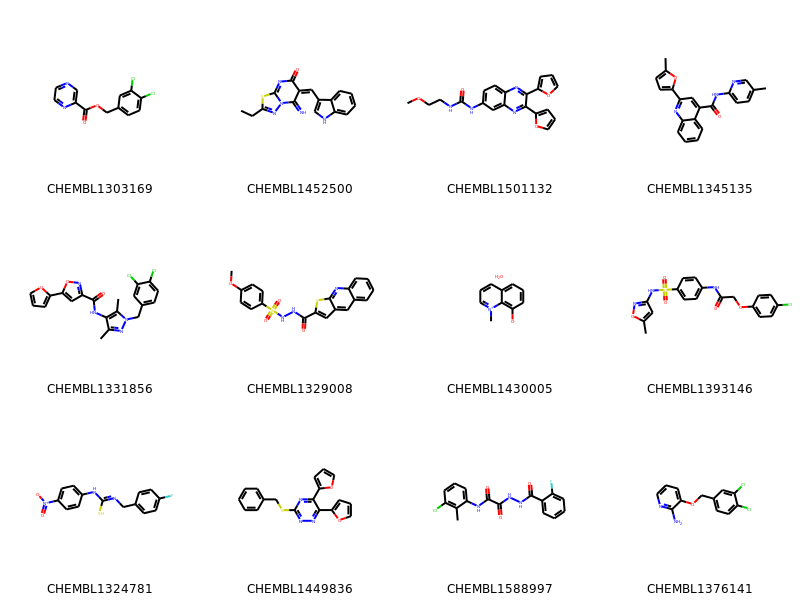

In [5]:
df['mol'] = df['Smiles'].apply(Chem.MolFromSmiles)
Draw.MolsToGridImage(df.iloc[:12]['mol'],molsPerRow=4,legends=list(df.iloc[:12]['Molecule ChEMBL ID'].values))

In [6]:
from rdkit.Chem import Descriptors

The molecules have a whole set of properties, that can be useful for comparing them, such as size (Molecular Weight), flexibility (number of rotatable bonds) or hydrophobicity (how _happy_ it is to be found in water vs hydrophobic solvent, [partition coefficient](https://en.wikipedia.org/wiki/Partition_coefficient), logP). ChEMBL computed these for us, but we can do it with RDKit [Descriptors](https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html) module as well.  Note that there may be discrepancies between two.

In [7]:
df['MolLogP'] = df['mol'].apply(Descriptors.MolLogP)
df['AMW'] = df['mol'].apply(Descriptors.MolWt)
df['NumRotatableBonds'] = df['mol'].apply(Descriptors.NumRotatableBonds)
df.iloc[100]

Molecule ChEMBL ID                                                 CHEMBL425686
Molecule Name                                                               NaN
Molecule Max Phase                                                            0
Molecular Weight                                                         318.39
#RO5 Violations                                                               0
AlogP                                                                      1.06
Compound Key                                                        SID90341144
Smiles                          C[N+]1(C)C2CC(OC(=O)[C@H](CO)c3ccccc3)CC1C1OC12
Standard Type                                                           Potency
Standard Relation                                                           NaN
Standard Value                                                             23.9
Standard Units                                                               nM
pChEMBL Value                           

We see, that there are few very small molecules, and most of the molecules in the data set are rather hydrophobic (logP > 0).

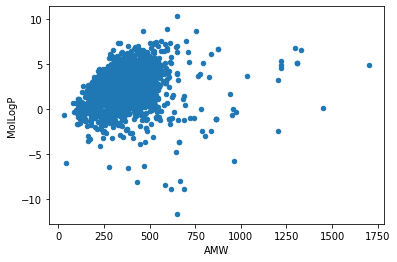

In [8]:
df.plot.scatter(x='AMW', y='MolLogP')

But maybe, there is a difference between actives and inactives? Let's see if this true. Activities vary by orders of magnitude, and in this case - the lower, the better.

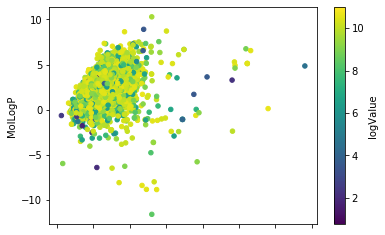

In [9]:
df_activity = df.loc[(df['Standard Type'] == 'Potency') & (df['Standard Units'] == 'nM')].dropna(subset=['Standard Value'])
df_activity['logValue'] = np.log(df_activity['Standard Value'])
df_activity.plot.scatter(x='AMW', y='MolLogP', c='logValue', cmap='viridis')

## Fingerprints and similarity search. Virtual screening.

Most of chemistry in living organisms (and not only) is composed of bits that have been proven to work well, such as functional groups. It is through these groups, that molecules interact. Therefore, if one compound is effective for a certain purpose, another one that has analogous functional groups that can come in a very similar arrangement, is likely to be functional as well. The assumption that similar compounds have similar activity is a basis for *virtual screening*, a very effective technique for identification of potential lead compounds. See Wikipedia for [Chemical Similarity](https://en.wikipedia.org/wiki/Chemical_similarity).

Therefore molecules can be represented as data structures, that describe their composition. The simplest ones are bit vectors, customarily called _molecular fingerprints_. Classic example of such a descriptor are Morgan (circular) fingerprints, which describe the molecule as a bag of fragments connected by a certain number of bonds (edges), so called _radius_. Here we will use radius of *2*, which renders a fingerprint called ECFP4. 

The most common way to compare fingerprints is Tanimoto index:

\begin{equation*}
Tanimoto(V_i, V_j) = \frac{V_i \cap V_j}{V_i \cap V_j}
\end{equation*}

So it is essentially, a Jaccard index, fraction of bits that are on in both vectors over the bits that are on in at least one.

For a bit more in-depth treatment, see Greg Landrum's, RDKit autor's, [talk](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf)



In [10]:
df['fp']=df['mol'].apply(AllChem.GetMorganFingerprintAsBitVect, args=(2, 2048))

In [11]:
import matplotlib.pyplot as plt
from rdkit.Chem import DataStructs

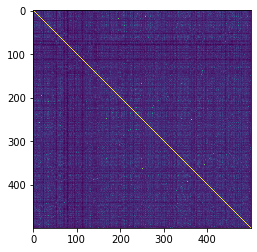

In [12]:
def pairwise_sim(mols):
    pairwise=np.zeros((len(mols), len(mols)))
    for i, m in enumerate(mols):
        sim = DataStructs.BulkTanimotoSimilarity(m,mols.tolist())
        pairwise[i,:] = sim
    return pairwise

similarity = pairwise_sim(df['fp'].iloc[:500])

plt.imshow(similarity)

As we see, each of the molecules is similar to itself, there is a _bit_ of background similarity, but then there are some molecules that are very similar to each other. These have a large overlap in their bit vectors and are likely to be similar in functionality too.

_A Big Pharma Industry Secret_ : In many cases, looking for similar drug candidates in pharmaceutical industry ends here.

But there is *much* more information we can use and vector similarity is not necessarily the best way to compare data points. 

We can do some machine learning instead! 

## Further feature engineering

Before embariking on any ML endeavor, we need to augment our data set with descriptive features. First, we need to add easily computable features, which we know are important for the purposes of drug discovery. For a bit more of in-depth description, see [here](http://www.esi.umontreal.ca/accelrys/life/cerius46/qsar/theory_descriptors.html).

In [13]:
df = df.dropna(subset=['mol'])
df['HeavyAtomCount'] = df['mol'].apply(Descriptors.HeavyAtomCount)
df['HAccept'] = df['mol'].apply(Descriptors.NumHAcceptors)
df['HDonor'] = df['mol'].apply(Descriptors.NumHDonors)
df['Heteroatoms'] = df['mol'].apply(Descriptors.NumHeteroatoms)
df['RingCount'] = df['mol'].apply(Descriptors.RingCount)
df['SaturatedRings'] = df['mol'].apply(Descriptors.NumSaturatedRings)
df['AliphaticRings'] = df['mol'].apply(Descriptors.NumAliphaticRings)
df['AromaticRings'] = df['mol'].apply(Descriptors.NumAromaticRings)
df['Ipc'] = df['mol'].apply(Descriptors.Ipc)
df['HallKierAlpha'] = df['mol'].apply(Descriptors.HallKierAlpha)
df['NumValenceElectrons'] = df['mol'].apply(Descriptors.NumValenceElectrons)

In [14]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [15]:
df = df.loc[(df['Standard Type'] == 'Potency') & (df['Standard Units'] == 'nM')].dropna(subset=['Standard Value'])
df['logValue'] = -1 * np.log(df_activity['Standard Value'])
X = df[['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
       'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
       'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
       'NumValenceElectrons']]
y = df['logValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

# Default models
models = {"rf": RandomForestRegressor(n_estimators=100, random_state=42)}

scores = {}
for m in models:
    models[m].fit(X_train, y_train)
    scores[m + "_train"] = models[m].score(X_train, y_train, )
    y_pred = models[m].predict(X_test)
    scores[m + "_test"] = r2_score(y_test, y_pred)
    scores[m + "_mse_test"] = mean_squared_error(y_test, y_pred)
    

scores = pd.Series(scores).T
scores

rf_train       0.853873
rf_test       -0.028772
rf_mse_test    2.143901
dtype: float64

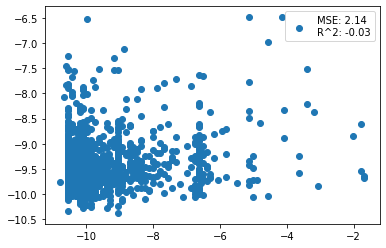

In [16]:
r_2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
plt.scatter(y_test, y_pred, label = "MSE: {:.2f}\nR^2: {:.2f}".format(mse, r_2))
plt.legend()
plt.show()

This is not very good, is it?  Let's see if fingerprints work better. First, let's add two more

In [17]:
df["ECFP6"] = df['mol'].apply(AllChem.GetMorganFingerprintAsBitVect, args=(3, 2048))
df["RDKFP"] = df['mol'].apply(AllChem.RDKFingerprint, fpSize=2048)

And let's try a multi-layer perceptron and a support vector regressor, for reference

In [18]:
# It takes some time, so for the sake of demonstration I will subsample the dataset
df = df.sample(frac=0.4)
y = -1*df['logValue']

models = {"rf": RandomForestRegressor(n_estimators=100, random_state=1337),
          "nnet": MLPRegressor(random_state=1337),
          "svr": SVR(gamma='auto')}
scores = {}


for f in ['fp', 'ECFP6', 'RDKFP']:
    scores[f] = {}
    # Convert fps to 2D numpy array
    X = np.array(df[f].tolist())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    for m in models:
        models[m].fit(X_train, y_train)
        y_pred = models[m].predict(X_test)
        scores[f][m + "_r2_test"] = r2_score(y_test, y_pred)
        scores[f][m + "_mse_test"] = mean_squared_error(y_test, y_pred)

/home/marcin/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/marcin/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [19]:
scores_df = pd.DataFrame(scores).T
scores_df

,rf_r2_test,rf_mse_test,nnet_r2_test,nnet_mse_test,svr_r2_test,svr_mse_test
fp,-0.073480,1.964012,-3.777295,8.740420,-0.150717,2.105324
ECFP6,-0.040009,1.902775,-3.799912,8.781799,-0.148688,2.101611
RDKFP,-0.035351,1.894252,-1.520716,4.611839,-0.091490,1.996963
